# Preliminaries

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from tqdm.notebook import tqdm
from datetime import date, timedelta
from pandas_datareader import data as pdr
import yfinance as yf
np.random.seed(42)

# Google stock data

In [2]:
yf.pdr_override()
start = date(2021, 1, 1)
end = date(2022, 1, 1)
googlframe = pdr.get_data_yahoo("GOOGL", start="2020-01-01", end="2021-01-01")
display(googlframe.head())
display(googlframe.tail())

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-01-02  67.420502  68.433998  67.324501  68.433998  68.433998  27278000
2020-01-03  67.400002  68.687500  67.365997  68.075996  68.075996  23408000
2020-01-06  67.581497  69.916000  67.550003  69.890503  69.890503  46768000
2020-01-07  70.023003  70.175003  69.578003  69.755501  69.755501  34330000
2020-01-08  69.740997  70.592499  69.631500  70.251999  70.251999  35314000

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-24  86.449997  87.120499  86.217499  86.708000  86.708000   9312000
2020-12-28  87.245499  89.349998  87.091003  88.697998  88.697998  27650000
2020-12-29  89.361504  89.423500  87.755501  87.888000  87.888000  19726000
2020-12-30  88.250000  88.388000  86.400002  86.812500  86.812500  21026000
2020-12-31  86.863503  87.875000  86.804497  87.632004  87.632004  21070000

<AxesSubplot:xlabel='Date'>

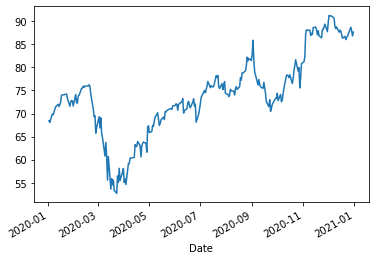

In [3]:
googlframe['Adj Close']['2020-01-01':'2021-01-01'].plot()

# SDE

$d S_{t}= r S_{t} d t+\sigma S_{t} dW_{t}$

In [4]:
from numpy import sqrt, exp, cumsum, sum, maximum, mean
from numpy.random import standard_normal

# Parameters

In [522]:
S0 = 100   # initial price
K = 100      # strike price
r = 0.01     # risk-free interest rate
sigma = 0.15 # volatility
T0 = date.today() # today's date
T1 = date(2023,12,1)  # start date of asian option average
T2 = date(2023,12,31) # maturity date
# T2 = T0 + timedelta(days=5)
T = ((T2-T0).days)/365 # time to maturity in years
N = (T2-T0).days # number of time steps
dt = T/N     # time step size
M = 1000     # number of simulations

In [6]:
print(T)
print(N)
print(dt)
print((T1-T0).days)
(T2-T1).days

0.40821917808219177
149
0.0027397260273972603
119


30

# Base class for random walk models

In [296]:
class BaseSimulator:
    def __init__(self, model_name, S0, K, r, sigma, T, N, M, T0, T2, phis=[]):
        self.model_name = model_name
        self.S0 = S0  # initial price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.T0 = T0  # start date
        self.T2 = T2  # maturity date
        self.realisations = None    # full path of realisations
        self.av_realisations = None # antithetic variate paths
        self.expiry_prices = None # expiry prices
        self.phis = phis # sequence of noise
        self.option_price = None # estimated option price
        self.payoffs = None # payoffs of each simulation
        self.antithetic_variates = False
        self.av_option_price = None # estimated option price with antithetic variate
        self.av_payoffs = None

    def get_option_price(self, option_type="c"):
        """
        calculate payoffs and dicounted option price
        
        Parameters:
            option_type (str): c -> call option, p -> put option
        """
        self.expiry_prices = self.realisations[-1]
        payoffs = (self.expiry_prices - self.K) if (option_type=="c") else (self.K - self.expiry_prices)
        self.payoffs = maximum(payoffs, 0)

        if (self.antithetic_variates==True):
            av_expiry_prices = self.av_realisations[-1]
            av_payoffs = (av_expiry_prices - self.K) if (option_type=="c") else (self.K - av_expiry_prices)
            av_payoffs = maximum(av_payoffs, 0)
            self.av_payoffs = 0.5 * (self.payoffs + av_payoffs)
            self.av_option_price = np.exp(-self.r*self.T) * sum(self.av_payoffs)/self.M
            return self.av_option_price
        else:
            self.option_price = exp(-self.r*self.T) * sum(self.payoffs)/self.M
            return self.option_price
    
    def sample_path_model(self):
        # function for defining how asset sample path should be generated
        raise NotImplementedError("Subclass must implement abstract method")

    def generate_sample_paths(self, antithetic_variates=False):
        """
        function for generating random walks/realisations
        
        Parameters:
            antithetic_variates (bool): activate antithetic variate method
        """        
        # initialise arrays of random variables
        if (len(self.phis) == 0):
            self.phis = np.random.normal(0, 1, size=(self.N, self.M))
        
        # generate sample paths with the specified path generating model
        self.antithetic_variates = antithetic_variates
        self.sample_path_model()
    
    def plot_n_realisations(self, n=0, display_mode=0):
        """
        Parameters:
            n (int): number of sample paths to plot
            display_mode (int): 0 -> plot standard realisations
                                1 -> plot realisations of antithetic varaites
                                2 -> plot both realisations
        """
        
        n = n if n > 0 else self.M
        timeline = pd.date_range(start=self.T0,end=self.T2)
        if (display_mode==1):
            plt.plot(timeline, self.av_realisations[:, :n])
        elif (display_mode==2):
            plt.plot(timeline, self.realisations[:, :n], color='blue')
            plt.plot(timeline, self.av_realisations[:, :n], color='orange')
            plt.plot(self.T0, self.S0, color='blue', label="standard")
            plt.plot(self.T0, self.S0, color='orange', label="antithetic variate")
            plt.legend()
        else:
            plt.plot(timeline, self.realisations[:, :n])

        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Simulated Time Series using {self.model_name} method')
        plt.show()

# Closed Form Solution for vanilla European options

$S_T=S_0 \exp \left\{\left(r-\frac{1}{2} \sigma^2\right) T+\sigma \phi \sqrt{T}\right\}$  
This is a closed form solution where the final price at expiry can be calculated in one giant step T.  
Integrated over [0,T]

In [223]:
# initialise random values
phi = standard_normal(M)

# Simulate I outcome
S = S0 * exp((r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * phi)
payoffs = maximum(S-K, 0)

# Calculate the Monte Carlo estimator
C0 = exp(-r * T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % C0)

Estimated present value is 0.451337


# Euler discretisation on log price - optimised
$S_{t + \delta t} = S_t e^{\left(r - \frac{1}{2}\sigma^2\right)\delta t + \sigma\phi\sqrt{\delta t}}$  
Time stepping solution following Euler discretisation method, integrate over [$t, t+\delta t$]

In [297]:
class Euler_discretisation_fast_simulator(BaseSimulator):
    def sample_path_model(self):
        drift = (self.r - 0.5*self.sigma**2)*self.dt
        diffusion = self.sigma*np.sqrt(self.dt)*self.phis
        delta_St = drift + diffusion
        self.realisations = self.S0*np.cumprod(np.exp(delta_St), axis=0)
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))
        
        # use negative counterpart of the phis to generate antithetic variates
        if (self.antithetic_variates):
            delta_St_av = drift - diffusion
            self.av_realisations = self.S0*np.cumprod(np.exp(delta_St_av), axis=0)
            # prepend initial price S0 to the realisations
            self.av_realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.av_realisations))

### Call option - normal

In [507]:
start_time = time.time()
ed_simulator = Euler_discretisation_fast_simulator("Euler-discretisation", S0, K, r, sigma, T, N, M, T0, T2)
ed_simulator.generate_sample_paths(antithetic_variates=False)
ed_option_price = ed_simulator.get_option_price()
print("Estimated present value is: %f" % ed_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is: 7.162010
Computation time is:  3.3034


### Call option - with antithetic variate method

In [264]:
start_time = time.time()
ed_simulator = Euler_discretisation_fast_simulator("Euler-discretisation", S0, K, r, sigma, T, N, M, T0, T2)
ed_simulator.generate_sample_paths(antithetic_variates=True)
ed_option_price = ed_simulator.get_option_price()
print("Estimated present value is: %f" % ed_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is: 0.392139
Computation time is:  0.0181


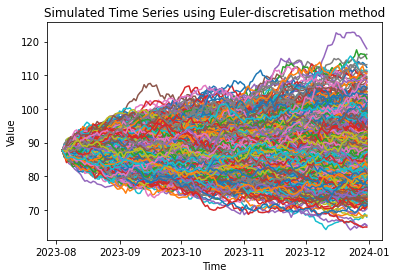

In [239]:
# plot the original set of realisations
ed_simulator.plot_n_realisations()

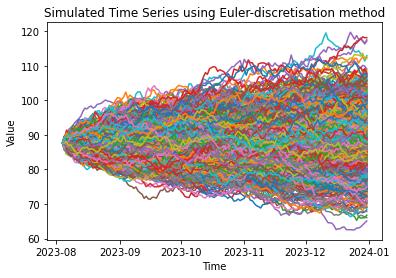

In [240]:
# plot realisations of antithetic varites
ed_simulator.plot_n_realisations(display_mode=1)

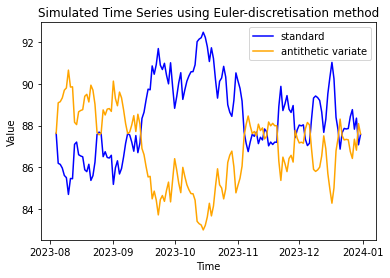

In [241]:
# plot both original and antithetic realisations for verification purpose
ed_simulator.plot_n_realisations(n=1, display_mode=2)

# Forward Euler-Maruyama method - slow
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [9]:
# function to run one simulation
def simulate_Euler_Maruyama():
    # Initialize the time series
    S = np.zeros(N+1)
    S[0] = S0
    
    # perform one realisation
    for i in range(N):
        _phi = np.random.normal(0, 1)
        S[i+1] = S[i] * (1 + r*dt + sigma*_phi*sqrt(dt))
    return S[-1]

start_time = time.time()
payoffs = maximum(np.array([simulate_Euler_Maruyama() for i in range(M)]) - K, 0)
option_price = exp(-r*T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.471282
Computation time is:  0.893


In [10]:
class Euler_Maruyama_simulator:
    def __init__(self, S0, K, r, sigma, T, N, M):
        self.S0 = S0
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = [] # full path of realisations
        self.expiry_price = [] # expiry prices

    def perform_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisaztion
        for i in range(self.N):
            _phi = np.random.normal(0, 1)
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*_phi*sqrt(self.dt))
        self.realisations.append(S)
        self.expiry_price.append(S[-1])
    
    def run_monte_carlo(self):
        for i in range(self.M) : self.perform_realisation()
        payoffs = maximum(np.array(self.expiry_price) - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
    
    def plot_n_realisations(self, n):
        timeline = pd.date_range(start=T0,end=T2)
        for i in range(n):
            plt.plot(timeline, self.realisations[i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simulated Time Series using Euler-Maruyama method')
        plt.show()

In [11]:
start_time = time.time()
EM_simulator = Euler_Maruyama_simulator(S0, K, r, sigma, T, N, M)
EM_option_price = EM_simulator.run_monte_carlo()
print("Estimated present value is %f" % EM_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.443695
Computation time is:  0.8588


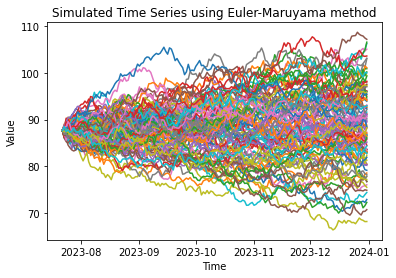

In [12]:
EM_simulator.plot_n_realisations(100)

# Forward Euler-Maruyama method - optimised
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [298]:
class Euler_Maruyama_fast_simulator(BaseSimulator):
    def sample_path_model(self):
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))
        
        # use negative counterpart of the phis to generate antithetic variates
        if (self.antithetic_variates):
            delta_St_av = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*(-self.phis)
            self.av_realisations = self.S0*np.cumprod(delta_St_av, axis=0)
            # prepend initial price S0 to the realisations
            self.av_realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.av_realisations))

### Call Option

In [243]:
start_time = time.time()
em_simulator_call = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M, T0, T2)
em_simulator_call.generate_sample_paths(antithetic_variates=True)
em_call_option_price = em_simulator_call.get_option_price()
print("Estimated present value is %f" % em_call_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.323865
Computation time is:  0.0184


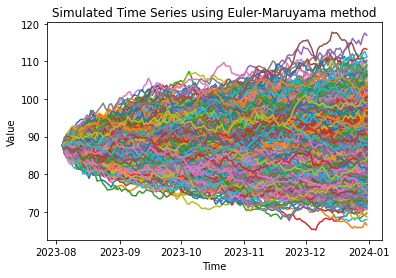

In [244]:
em_simulator_call.plot_n_realisations()

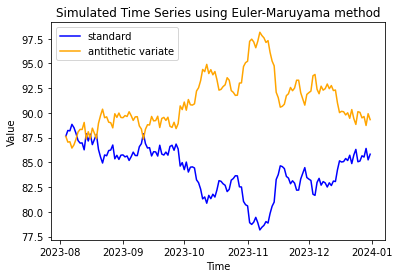

In [245]:
em_simulator_call.plot_n_realisations(n=1, display_mode=2)

### Put Option

In [246]:
start_time = time.time()
em_simulator_put = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M, T0, T2)
em_simulator_put.generate_sample_paths(antithetic_variates=True)
em_put_option_price = em_simulator_put.get_option_price("p")
print("Estimated present value is %f" % em_put_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 12.359672
Computation time is:  0.0232


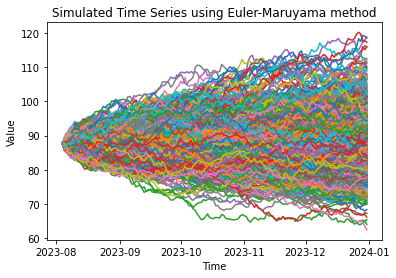

In [247]:
em_simulator_put.plot_n_realisations()

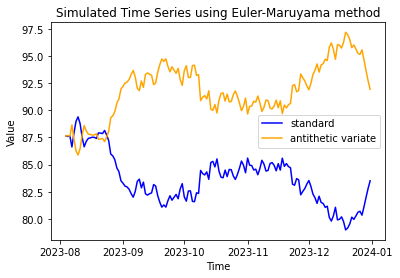

In [248]:
em_simulator_put.plot_n_realisations(n=1, display_mode=2)

# Milstein method - slow
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [18]:
# function to run one simulation
def simulate_Milstein():
    # Initialize the time series
    S = np.zeros(N+1)
    S[0] = S0
    
    # perform one realisaztion
    for i in range(N):
        _phi = np.random.normal(0, 1)
        S[i+1] = S[i] * (1 + r*dt + sigma*_phi*sqrt(dt) + 0.5*(sigma**2)*(_phi**2 - 1)*dt)
    return S[-1]

start_time = time.time()
payoffs = maximum(np.array([simulate_Milstein() for i in range(M)]) - K, 0)
option_price = exp(-r*T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.447738
Computation time is:  0.9833


In [19]:
class Milstein_simulator:
    def __init__(self, S0, K, r, sigma, T, N, M):
        self.S0 = S0
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = []  # full paths of realisations
        self.expiry_prices = [] # expiry prices
        
    def perform_realisation(self):
        # Initialise the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisaztion
        for i in range(self.N):
            _phi = np.random.normal(0, 1)
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*_phi*sqrt(self.dt) + 0.5*(self.sigma**2)*(_phi**2 - 1)*self.dt)
        self.realisations.append(S)
        self.expiry_prices.append(S[-1])
    
    def run_monte_carlo(self):
        for i in range(self.M) : self.perform_realisation()
        payoffs = maximum(np.array(self.expiry_prices) - K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
    
    def plot_n_realisations(self, n):
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            plt.plot(x, self.realisations[i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simulated Time Series using Milstein method')
        plt.show()

In [20]:
start_time = time.time()
M_simulator = Milstein_simulator(S0, K, r, sigma, T, N, M)
M_option_price = M_simulator.run_monte_carlo()
print("Estimated present value is %f" % M_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.435006
Computation time is:  0.9995


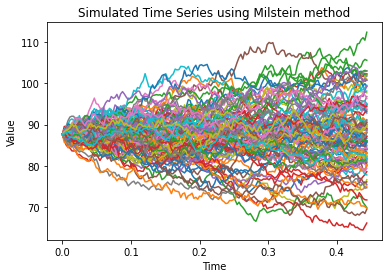

In [21]:
M_simulator.plot_n_realisations(100)

# Milstein method - optimised
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [299]:
class Milstein_fast_simulator(BaseSimulator):
    def sample_path_model(self):
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis + 0.5*(self.sigma**2)*(np.square(self.phis)-1)*self.dt
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))
        
        # use negative counterpart of the phis to generate antithetic variates
        if (self.antithetic_variates):
            delta_St_av = 1 + self.r*self.dt - self.sigma*np.sqrt(self.dt)*self.phis + 0.5*(self.sigma**2)*(np.square(self.phis)-1)*self.dt
            self.av_realisations = self.S0*np.cumprod(delta_St_av, axis=0)
            # prepend initial price S0 to the realisations
            self.av_realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.av_realisations))

### Call Option

In [250]:
start_time = time.time()
mil_simulator_call = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2)
mil_simulator_call.generate_sample_paths(antithetic_variates=True)
mil_call_option_price = mil_simulator_call.get_option_price()
print("Estimated present value is %f" % mil_call_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 0.384722
Computation time is:  0.0492


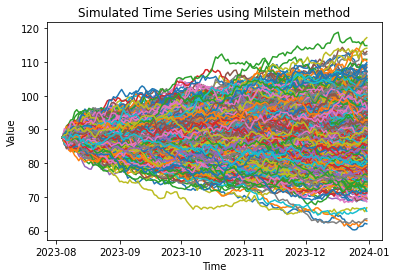

In [251]:
mil_simulator_call.plot_n_realisations()

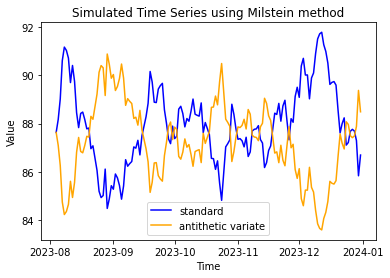

In [252]:
mil_simulator_call.plot_n_realisations(n=1, display_mode=2)

### Put Option

In [253]:
start_time = time.time()
mil_simulator_put = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2)
mil_simulator_put.generate_sample_paths(antithetic_variates=True)
mil_put_option_price = mil_simulator_put.get_option_price("p")
print("Estimated present value is %f" % mil_put_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 12.337872
Computation time is:  0.0213


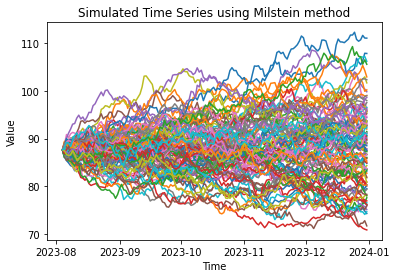

In [132]:
mil_simulator_put.plot_n_realisations(100)

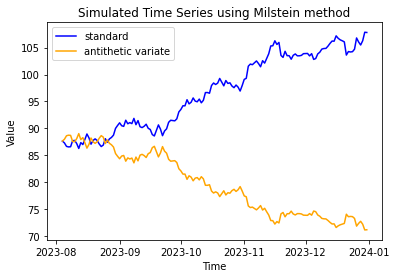

In [133]:
mil_simulator_put.plot_n_realisations(n=1, display_mode=2)

# Monte Carlo Simulator
The same set of phis is used for both Euler-Maruyama and Milstein methods for comparison.

In [27]:
class MC_simulator:
    def __init__(self, S0, K, r, sigma, T, N, I):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.I = I    # number of simulations
        self.Milstein_realisations = [] # full path of realisations using Milstein
        self.Milstein_expiry_prices = []
        self.Euler_Maruyama_realisations = [] # full path of realisations using Euler Maruyama
        self.Euler_Maruyama_expiry_prices = []
        self.phis = None # sequence of noise
    
    def perform_Euler_Maruyama_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisation
        for i in range(self.N):
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*self.phis[i]*sqrt(self.dt))
        self.Euler_Maruyama_realisations.append(S)
        self.Euler_Maruyama_expiry_prices.append(S[-1])
        
    def perform_Milstein_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisation
        for i in range(self.N):
            S[i+1] = S[i] * (1 + self.r*self.dt + sigma*self.phis[i]*sqrt(self.dt) + 0.5*(self.sigma**2)*(self.phis[i]**2 - 1)*self.dt)
        self.Milstein_realisations.append(S)
        self.Milstein_expiry_prices.append(S[-1])
    
    def calculate_option_price(self, expiry_prices):
        payoffs = maximum(np.array(expiry_prices) - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
        
    def run_monte_carlo(self):
        # Run I number of simulations
        print('Start running simulations...')
        for i in tqdm(range(self.I)):
            self.phis = standard_normal(self.N)
            self.perform_Euler_Maruyama_realisation()
            self.perform_Milstein_realisation()
        
        # price the option
        EM_option_price = self.calculate_option_price(self.Euler_Maruyama_expiry_prices)
        M_option_price = self.calculate_option_price(self.Milstein_expiry_prices)
        return (EM_option_price, M_option_price)
    
    def plot_n_realisations(self, n):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
        # plots Euler-Maruyama realisations
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            axes[0].plot(x, self.Euler_Maruyama_realisations[i])   
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Value')
        axes[0].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        for i in range(n):
            axes[1].plot(x, self.Milstein_realisations[i])   
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Value')
        axes[1].set_title('Simulated Time Series using Milstein method')
        
        fig.tight_layout()
        plt.show()
    
    def comparing_ith_realisations(self, ith_rls):
        x = np.linspace(0.0, self.T, self.N+1)
        plt.figure(figsize=(13, 6))
        plt.plot(x, self.Euler_Maruyama_realisations[ith_rls], label='Euler-Maruyama')
        plt.plot(x, self.Milstein_realisations[ith_rls], label='Milstein')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()

# Monte Carlo simulator - optimised 
The same set of phis is used for Euler-discretisation, Euler-Maruyama and Milstein methods for comparison.

In [379]:
class MC_simulator_optimised:
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, simulator, phis=[]):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.M = M    # number of simulations
        self.T0 = T0  # start date
        self.T2 = T2  # maturity date
        self.dt = T/N # time step size
        self.simulator  = simulator # asset path generator
        self.phis = phis # sequence of noise
        self.mil_simulator = None
        self.em_simulator = None
        self.ed_simulator = None
        self.antithetic_variates = False
        
    def standard_error(self, payoffs, option_price):
        # sample standard deviation
        std_dev = np.sqrt(np.sum((exp(-self.r*self.T)*payoffs - option_price)**2) / (self.M-1))
        
        # standard error
        SE = std_dev/np.sqrt(self.M)
        return SE
    
    def get_European_option_price(self, option_type):
        # price the option
        option_price = self.simulator.get_option_price(option_type)
        SE = 0
        if (self.antithetic_variates):
            SE = self.standard_error(self.simulator.av_payoffs, self.simulator.av_option_price)
        else:
            SE = self.standard_error(self.simulator.payoffs, self.simulator.option_price)
        return (option_price, SE)
        
    def run_monte_carlo(self, antithetic_variates):
        self.antithetic_variates = antithetic_variates
        self.simulator.generate_sample_paths(antithetic_variates)

    def update_model(self, simulator_model):
        self.simulator = simulator_model
        

    def comparing_ith_realisations(self, simulators, ith_rls):
        timeline = pd.date_range(start=self.T0,end=self.T2)
        plt.figure(figsize=(13, 6))
        
        for simulator in simulators:
            plt.plot(timeline, simulator.realisations[:,ith_rls], label=simulator.model_name)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()
    
    def plot_n_realisations(self, simulators, n=0):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 6))
        n = n if n > 0 else self.M
        timeline = pd.date_range(start=self.T0,end=self.T2)
                
        # plots Euler discretisation realisations
        axes[0, 0].plot(timeline, simulators[0].realisations[:, :n])
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].set_ylabel('Value')
        axes[0, 0].set_title('Simulated Time Series using Euler discretisation method')
        
        # plots Euler-Maruyama realisations
        axes[0, 1].plot(timeline, simulators[1].realisations[:, :n])
        axes[0, 1].set_xlabel('Time')
        axes[0, 1].set_ylabel('Value')
        axes[0, 1].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        axes[1, 0].plot(timeline, simulators[2].realisations[:, :n])
        axes[1, 0].set_xlabel('Time')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].set_title('Simulated Time Series using Milstein method')
        
        axes[1, 1].axis('off')
        fig.tight_layout()
        plt.show()


### European Call Option - standard realisations

In [285]:
phis = np.random.normal(0, 1, size=(N,M))

start_time = time.time()
ed_simulator_call = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=False)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
eu_simulator_call = Euler_Maruyama_fast_simulator("Euler Maruyama", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, eu_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=False)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Euler Maruyama: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
mil_simulator_call = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, mil_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=False)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Milstein: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))


Start running simulations...
Euler discretisation: Estimated present value is 0.5279 with standard error 0.071
Computation time is:  0.0085
Start running simulations...
Euler Maruyama: Estimated present value is 0.5286 with standard error 0.071
Computation time is:  0.0025
Start running simulations...
Milstein: Estimated present value is 0.5279 with standard error 0.071
Computation time is:  0.0075


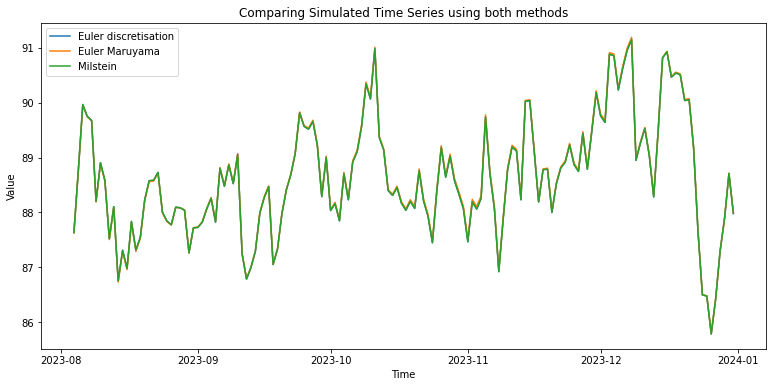

In [286]:
mc_simulator.comparing_ith_realisations([ed_simulator_call, eu_simulator_call, mil_simulator_call], 1)

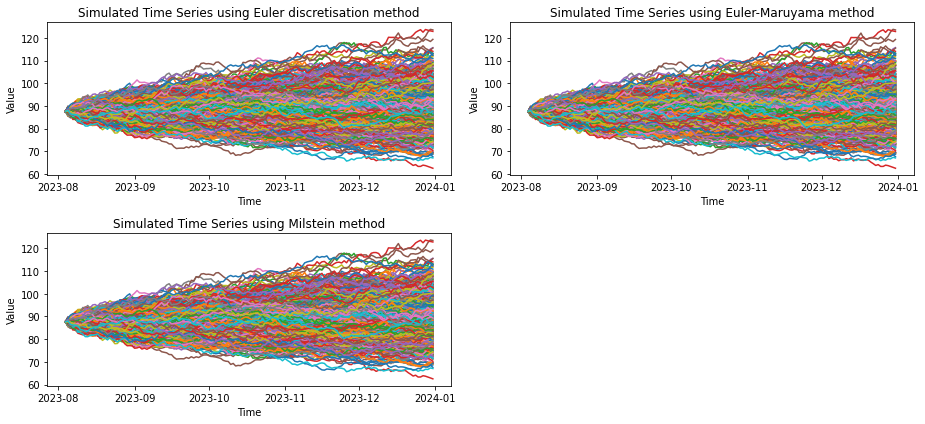

In [289]:
mc_simulator.plot_n_realisations([ed_simulator_call, eu_simulator_call, mil_simulator_call])

### European Call Option - realisations with antithetic variate

In [287]:
start_time = time.time()
ed_simulator_call = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
eu_simulator_call = Euler_Maruyama_fast_simulator("Euler Maruyama", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, eu_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Euler Maruyama: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
mil_simulator_call = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, mil_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Milstein: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Start running simulations...
Euler discretisation: Estimated present value is 0.419 with standard error 0.043
Computation time is:  0.0303
Start running simulations...
Euler Maruyama: Estimated present value is 0.4188 with standard error 0.043
Computation time is:  0.0078
Start running simulations...
Milstein: Estimated present value is 0.419 with standard error 0.043
Computation time is:  0.0087


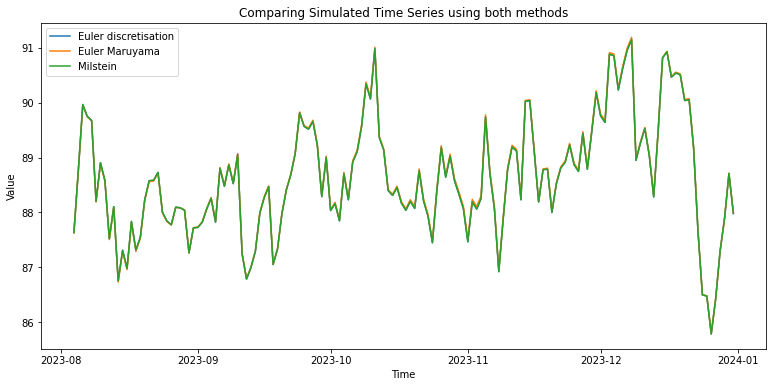

In [288]:
mc_simulator.comparing_ith_realisations([ed_simulator_call, eu_simulator_call, mil_simulator_call], 1)

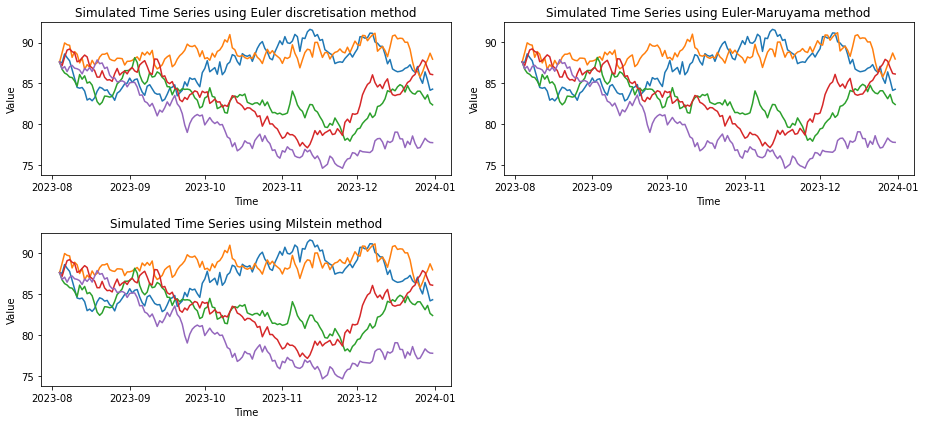

In [290]:
mc_simulator.plot_n_realisations([ed_simulator_call, eu_simulator_call, mil_simulator_call], 5)

### European Put Option - with antithetic variate

In [294]:
start_time = time.time()
ed_simulator_put= Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator_put)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='p')
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
eu_simulator_put = Euler_Maruyama_fast_simulator("Euler Maruyama", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, eu_simulator_put)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='p')
print("Euler Maruyama: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
mil_simulator_put = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, mil_simulator_put)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='p')
print("Milstein: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Start running simulations...
Euler discretisation: Estimated present value is 12.3711 with standard error 0.025
Computation time is:  0.0156
Start running simulations...
Euler Maruyama: Estimated present value is 12.3683 with standard error 0.025
Computation time is:  0.0049
Start running simulations...
Milstein: Estimated present value is 12.371 with standard error 0.025
Computation time is:  0.0057


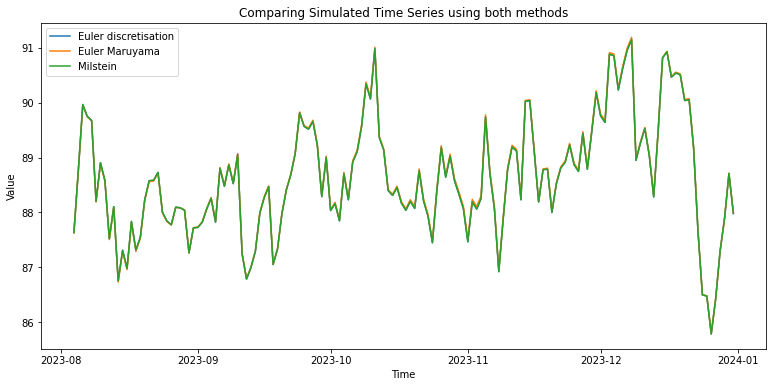

In [292]:
mc_simulator.comparing_ith_realisations([ed_simulator_put, eu_simulator_put, mil_simulator_put], 1)

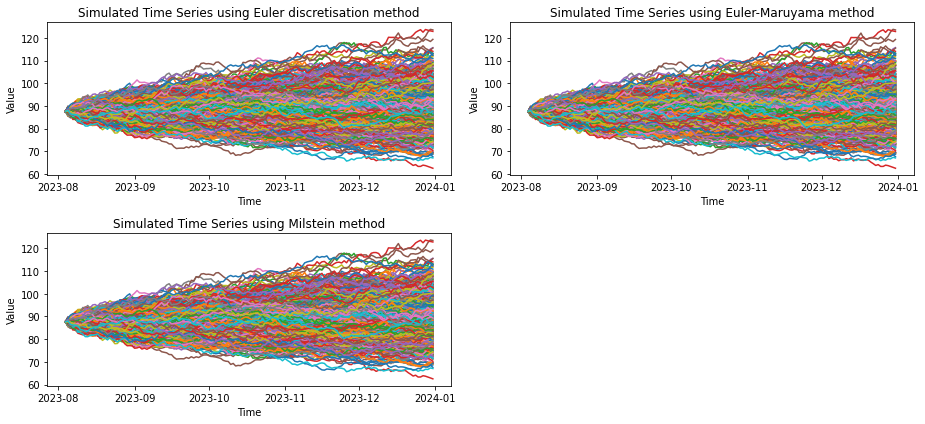

In [293]:
mc_simulator.plot_n_realisations([ed_simulator_put, eu_simulator_put, mil_simulator_put])

# Barrier Options

1. up-and-in call option
1. up-and-out call option
1. down-and-in call option
1. down-and-out call option
1. up-and-in put option
1. up-and-out put option
1. down-and-in put option
1. down-and-out put option

In [519]:
class BarrierOption(MC_simulator_optimised):
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, simulator, barrier_type, H_bound, L_bound):
        super().__init__(S0, K, r, sigma, T, N, M, T0, T2, simulator)
        self.barrier_type = barrier_type # int: corresponds to the indexes listed above
        self.H_bound = H_bound   # upper barrier
        self.L_bound = L_bound   # lower barrier
        self.mask_1 = None
        self.mask_2 = None
        self.title = 'European Up-and-Out Call Option'
        self.main_type = "Call" if (barrier_type < 5) else "Put"
        self.barrier_price = 0
        self.barrier_payoffs = None
    
    def calculate_option_price(self):
        """
        barrier_type < 5  : call option => ST - K
        barrier_type >= 5 : put option  => K - ST
        """
        S_expiry = self.simulator.realisations[-1,:].copy()
        S_expiry[self.mask_1] = 0
        payoffs = (S_expiry - self.K) if (self.barrier_type < 5) else (self.K - S_expiry)
        payoffs = np.maximum(0, payoffs)
        
        if (self.antithetic_variates):
            S_expiry_2 = self.simulator.av_realisations[-1,:].copy()
            S_expiry_2[self.mask_2] = 0
            payoffs_2 = (S_expiry_2 - self.K) if (self.barrier_type < 5) else (self.K - S_expiry_2)
            payoffs_2 = np.maximum(0, payoffs_2)
            av_payoffs = 0.5*(payoffs + payoffs_2)
            option_price = np.exp(-self.r*self.T)*np.sum(av_payoffs)/self.M
            self.barrier_payoffs = av_payoffs
            return option_price
        else:
            option_price = np.exp(-self.r*self.T)*np.sum(payoffs)/self.M
            self.barrier_payoffs = payoffs
            return option_price
        
    def up_and_in(self):
        self.title = 'European Up-and-In ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(self.simulator.realisations >= self.H_bound, axis=0)
        # reversing mask so realisations below barrier are nullified
        self.mask_1 = ~mask
        
        if (self.antithetic_variates):
            # change realisation values to 0 based on indexing mask
            mask_2 = np.any(self.simulator.av_realisations >= self.H_bound, axis=0)
            # reversing mask so realisations below barrier are nullified
            self.mask_2 = ~mask_2
        return self.calculate_option_price()
    
    def up_and_out(self):
        self.title = 'European Up-and-Out ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        self.mask_1 = np.any(self.simulator.realisations >= self.H_bound, axis=0)
        
        if (self.antithetic_variates):
            # change realisation values to 0 based on indexing mask
            self.mask_2 = np.any(self.simulator.av_realisations >= self.H_bound, axis=0)
        return self.calculate_option_price()
    
    def down_and_in(self):
        self.title = 'European Down-and-In ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(self.simulator.realisations <= self.L_bound, axis=0)
        # reversing mask so realisations above barrier are nullified
        self.mask_1 = ~mask
        
        if (self.antithetic_variates):
            # change realisation values to 0 based on indexing mask
            mask_2 = np.any(self.simulator.av_realisations <= self.L_bound, axis=0)
            # reversing mask so realisations below barrier are nullified
            self.mask_2 = ~mask_2
        return self.calculate_option_price()

    def down_and_out(self):
        self.title = 'European Down-and-Out ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        self.mask_1 = np.any(self.simulator.realisations <= self.L_bound, axis=0)
        
        if (self.antithetic_variates):
            # change realisation values to 0 based on indexing mask
            self.mask_2 = np.any(self.simulator.av_realisations <= self.L_bound, axis=0)
        return self.calculate_option_price()

    def get_Barrier_price(self):
        # price option based on barriers
        select_barrier = {
            1 : self.up_and_in,
            2 : self.up_and_out,
            3 : self.down_and_in,
            4 : self.down_and_out,
            5 : self.up_and_in,
            6 : self.up_and_out,
            7 : self.down_and_in,
            8 : self.down_and_out
        }
        self.barrier_price = select_barrier.get(self.barrier_type, self.up_and_in)()
        SE = self.standard_error(self.barrier_payoffs, self.barrier_price)
        return (self.barrier_price, SE)
    
    def plot_barrier_paths(self):
        plt.figure(figsize=(16, 6))
        timeline = pd.date_range(start=self.T0,end=self.T2)
        
        # plot realisations
        plt.plot(timeline, self.simulator.realisations[:,~self.mask_1],'g', alpha=0.5)
        plt.plot(self.T0, self.S0, 'g', label='active')
        plt.plot(timeline,self.simulator.realisations[:,self.mask_1],'r', alpha=0.3)
        plt.plot(self.T0, self.S0, 'r', label='inactive')
        
        # plot barriers
        if (self.barrier_type < 3 or (self.barrier_type > 4 and self.barrier_type < 7)):
            plt.axhline(y=self.H_bound, color='k', linestyle='--', linewidth=2.0, label='H_barrier')
        else:
            plt.axhline(y=self.L_bound, color='k', linestyle='--', linewidth=2.0, label='L_barrier')
                        
        plt.axhline(y=self.K, linestyle='--', color='blue',linewidth=2.0, label='strike price')
        plt.xlabel('Time')
        plt.ylabel('Price')
        _title = self.title + " : " + self.simulator.model_name + " random walks"
        plt.title(_title)
        plt.legend()
        plt.show()

In [351]:
phis = np.random.normal(0, 1, size=(N,M))

start_time = time.time()
ed_simulator_call = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)


barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, ed_simulator_call, 1, 100, 75)
barrier_option.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = barrier_option.get_European_option_price('c')
(barrier_price, SE_1) = barrier_option.get_Barrier_price()
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(barrier_price,4), round(SE_1,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Start running simulations...
Euler discretisation: Estimated present value is 0.3938 with standard error 0.038
Euler discretisation: Estimated present value is 0.9646 with standard error 0.063
Computation time is:  0.0085


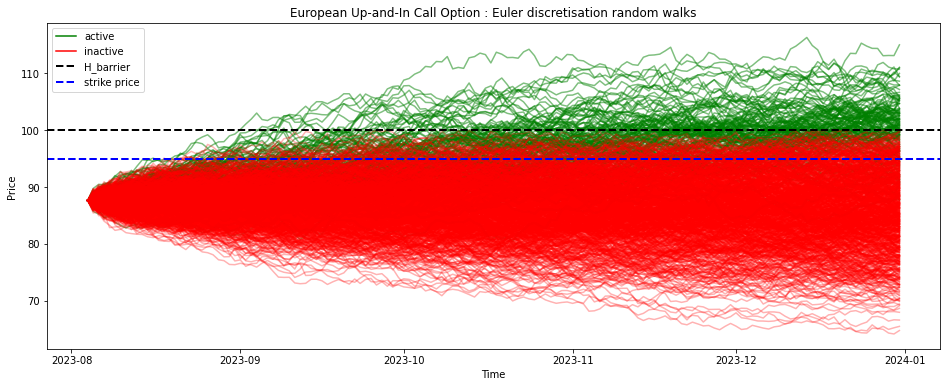

In [336]:
barrier_option.plot_barrier_paths()

## 1. European Up-and-In Call Option

In [523]:
# Barrier correction
S_u_new = S_u * np.exp(0.5863 * sigma * np.sqrt(dt))
S_d_new = S_d * np.exp(-0.5863 * sigma * np.sqrt(dt))
# Euler discretisation simulator
start_time = time.time()
ed_simulator = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2)
barrier_1 = BarrierOption(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator, 1, S_u_new, S_d_new)
barrier_1.run_monte_carlo(antithetic_variates=False)
(price_1, SE_1) = barrier_1.get_Barrier_price()
end_time_1 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Euler discretisation": [round(price_1,4)],
        "Error_1": [round(SE_1,5)],
        "Time_1": [end_time_1],
    }
)
results

Euler discretisation  Error_1  Time_1
0                3.0359   0.1961  0.0135

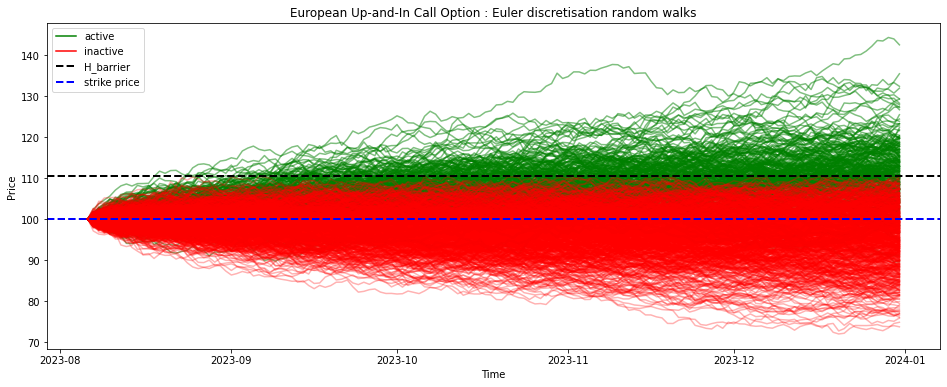

In [524]:
barrier_1.plot_barrier_paths()

## 2. European Up-and-Out Call Option

In [48]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 2, 100, 75)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('c')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

barrier_option_av = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 2, 100, 75)
barrier_option_av.run_monte_carlo(antithetic_variates=True)
(EM_barrier_price_av, M_barrier_price_av, EM_Barrier_SE_av, M_Barrier_SE_av) = barrier_option_av.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein", "Euler-Maruyama with antithetic variates", "Milstein with antithetic variates"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title, barrier_option_av.title, barrier_option_av.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price, EM_barrier_price_av, M_barrier_price_av],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE, EM_Barrier_SE_av, M_Barrier_SE_av]
    }
)
results

Start running simulations...
Start running simulations...


Method                      Option Type  \
0                           Euler-Maruyama                             Call   
1                                 Milstein                             Call   
2                           Euler-Maruyama  European Up-and-Out Call Option   
3                                 Milstein  European Up-and-Out Call Option   
4  Euler-Maruyama with antithetic variates  European Up-and-Out Call Option   
5        Milstein with antithetic variates  European Up-and-Out Call Option   

   Estimated Price  Standard Error  
0         1.274986        0.108874  
1         1.275805        0.108901  
2         0.106290        0.016383  
3         0.106621        0.016446  
4         0.113232        0.017514  
5         0.113099        0.017456

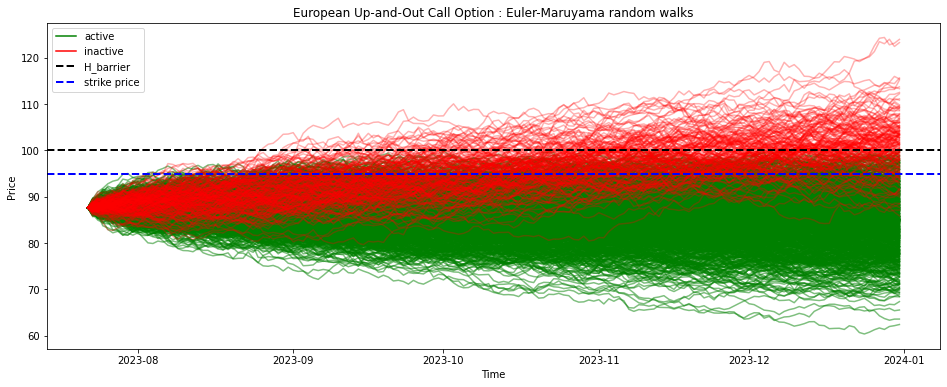

In [49]:
barrier_option.plot_barrier_paths()

## 3. European Down-and-In Call Option

In [50]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 3, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('c')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

barrier_option_av = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 3, 100, 80)
barrier_option_av.run_monte_carlo(antithetic_variates=True)
(EM_barrier_price_av, M_barrier_price_av, EM_Barrier_SE_av, M_Barrier_SE_av) = barrier_option_av.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein", "Euler-Maruyama with antithetic variates", "Milstein with antithetic variates"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title, barrier_option_av.title, barrier_option_av.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price, EM_barrier_price_av, M_barrier_price_av],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE, EM_Barrier_SE_av, M_Barrier_SE_av]
    }
)
results

Start running simulations...
Start running simulations...


Method                       Option Type  \
0                           Euler-Maruyama                              Call   
1                                 Milstein                              Call   
2                           Euler-Maruyama  European Down-and-In Call Option   
3                                 Milstein  European Down-and-In Call Option   
4  Euler-Maruyama with antithetic variates  European Down-and-In Call Option   
5        Milstein with antithetic variates  European Down-and-In Call Option   

   Estimated Price  Standard Error  
0         1.255603        0.107150  
1         1.255816        0.107218  
2         0.007973        0.006685  
3         0.008033        0.006726  
4         0.005930        0.003922  
5         0.006018        0.003956

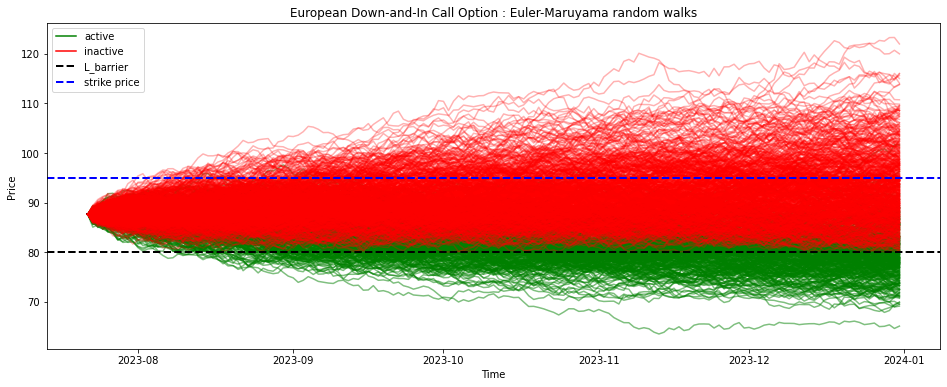

In [51]:
barrier_option.plot_barrier_paths()

## 4. European Down-and-Out Call Option

In [52]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 4, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('c')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

Start running simulations...


Method                        Option Type  Estimated Price  \
0  Euler-Maruyama                               Call         1.167244   
1        Milstein                               Call         1.167893   
2  Euler-Maruyama  European Down-and-Out Call Option         1.156184   
3        Milstein  European Down-and-Out Call Option         1.156776   

   Standard Error  
0        0.102659  
1        0.102725  
2        0.100040  
3        0.100090

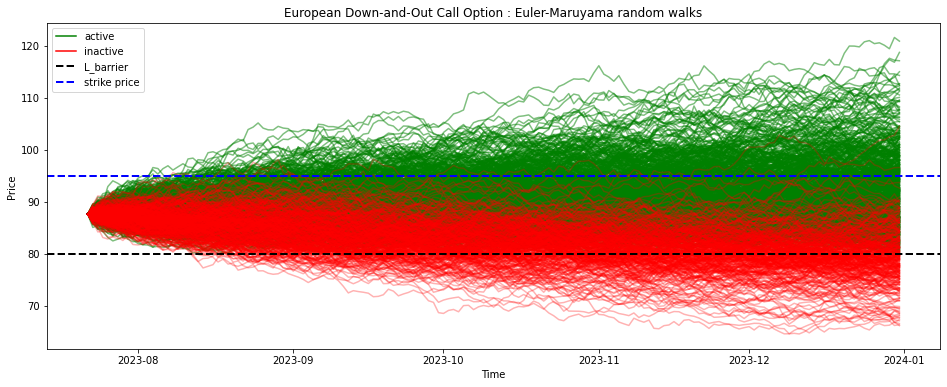

In [53]:
barrier_option.plot_barrier_paths()

## 5. European Up-and-In Put Option

In [54]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 5, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('p')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

Start running simulations...


Method                    Option Type  Estimated Price  \
0  Euler-Maruyama                            Put         8.542351   
1        Milstein                            Put         8.544946   
2  Euler-Maruyama  European Up-and-In Put Option         0.138078   
3        Milstein  European Up-and-In Put Option         0.150168   

   Standard Error  
0        0.216613  
1        0.216479  
2        0.030815  
3        0.033127

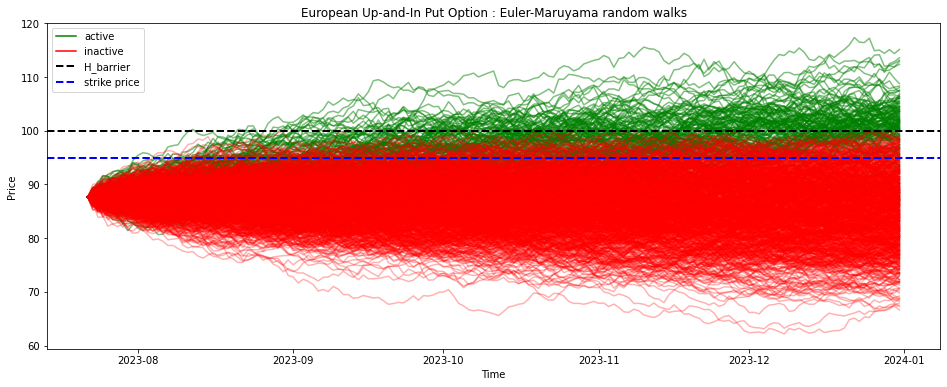

In [55]:
barrier_option.plot_barrier_paths()

## 6. European Up-and-Out Put Option

In [56]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 6, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('p')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

Start running simulations...


Method                     Option Type  Estimated Price  \
0  Euler-Maruyama                             Put         8.054634   
1        Milstein                             Put         8.055218   
2  Euler-Maruyama  European Up-and-Out Put Option         7.942277   
3        Milstein  European Up-and-Out Put Option         7.939709   

   Standard Error  
0        0.217746  
1        0.217663  
2        0.192457  
3        0.192330

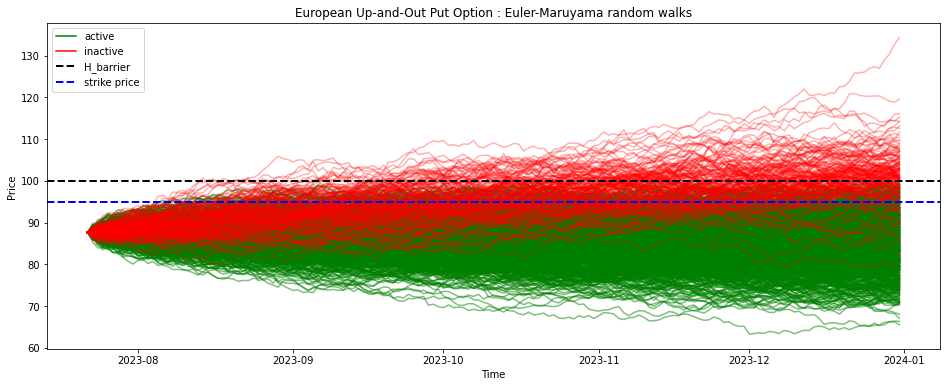

In [57]:
barrier_option.plot_barrier_paths()

## 7. European Down-and-In Put Option

In [58]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 7, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('p')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

barrier_option_av = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 7, 100, 80)
barrier_option_av.run_monte_carlo(antithetic_variates=True)
(EM_barrier_price_av, M_barrier_price_av, EM_Barrier_SE_av, M_Barrier_SE_av) = barrier_option_av.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein", "Euler-Maruyama with antithetic variates", "Milstein with antithetic variates"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title, barrier_option_av.title, barrier_option_av.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price, EM_barrier_price_av, M_barrier_price_av],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE, EM_Barrier_SE_av, M_Barrier_SE_av]
    }
)
results

Start running simulations...
Start running simulations...


Method                      Option Type  \
0                           Euler-Maruyama                              Put   
1                                 Milstein                              Put   
2                           Euler-Maruyama  European Down-and-In Put Option   
3                                 Milstein  European Down-and-In Put Option   
4  Euler-Maruyama with antithetic variates  European Down-and-In Put Option   
5        Milstein with antithetic variates  European Down-and-In Put Option   

   Estimated Price  Standard Error  
0         7.964641        0.219604  
1         7.964644        0.219566  
2         5.089742        0.208582  
3         5.093366        0.208493  
4         5.110818        0.207814  
5         5.133472        0.207615

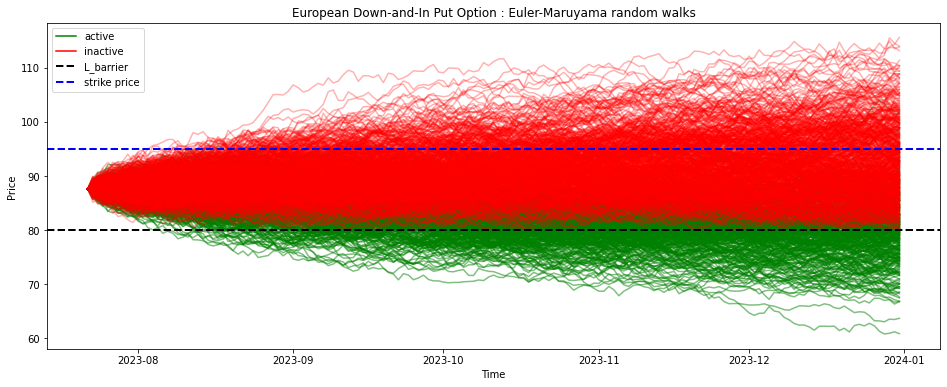

In [59]:
barrier_option.plot_barrier_paths()

## 8. European Down-and-Out Put Option

In [60]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, 8, 100, 80)
barrier_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = barrier_option.get_European_option_price('p')
(EM_barrier_price, M_barrier_price, EM_Barrier_SE, M_Barrier_SE) = barrier_option.get_Barrier_price()

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [barrier_option.main_type, barrier_option.main_type, barrier_option.title, barrier_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_barrier_price, M_barrier_price],
        'Standard Error': [EM_SE, M_SE, EM_Barrier_SE, M_Barrier_SE]
    }
)
results

Start running simulations...


Method                       Option Type  Estimated Price  \
0  Euler-Maruyama                               Put         7.811737   
1        Milstein                               Put         7.814553   
2  Euler-Maruyama  European Down-and-Out Put Option         2.840313   
3        Milstein  European Down-and-Out Put Option         2.843968   

   Standard Error  
0        0.218432  
1        0.218360  
2        0.117691  
3        0.117757

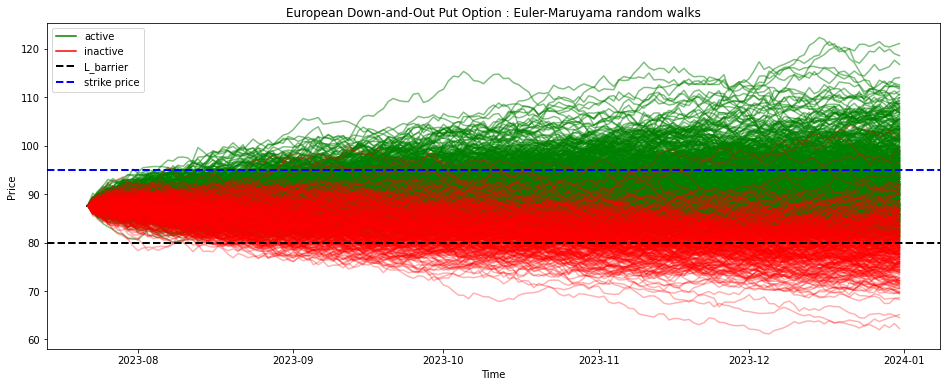

In [61]:
barrier_option.plot_barrier_paths()

# Barrier option Analysis

In [512]:
# Params
S0 = 100   # initial price
S_u = 110  # up barrier
S_d = 90   # down barrier
K = 105      # strike price
r = 0.03     # risk-free interest rate
sigma = 0.2 # voatility
# T0 = date.today() # today's date
T0 = date(2024,1,1)
T2 = date(2025,1,1) # maturity date
# T2 = T0 + timedelta(days=5)
T = ((T2-T0).days)/365 # time to maturity in years
N = (T2-T0).days # number of time steps
dt = T/N     # time step size
# Barrier correction
S_u_new = S_u * np.exp(0.5863 * sigma * np.sqrt(dt))
S_d_new = S_d * np.exp(-0.5863 * sigma * np.sqrt(dt))

In [493]:
def N_(x):
    # Define the standard normal distribution
    mean = 0
    std_dev = 1
    standard_normal = norm(loc=mean, scale=std_dev)
    return standard_normal.cdf(x)

def a(S0, S_b, r, sigma):
    return (S_b/S0)**(-1 + ((2*r)/(sigma**2)))

def b(S0, S_b, r, sigma):
    return (S_b/S0)**(1 + ((2*r)/(sigma**2)))

def d_1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_2(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_3(S0, S_b, r, sigma, T):
    return (np.log(S0/S_b) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_4(S0, S_b, r, sigma, T):
    return (np.log(S0/S_b) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_5(S0, S_b, r, sigma, T):
    return (np.log(S0/S_b) - (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_6(S0, S_b, r, sigma, T):
    return (np.log(S0/S_b) - (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_7(S0, S_b, K, r, sigma, T):
    return (np.log((S0*K)/(S_b**2)) - (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_8(S0, S_b, K, r, sigma, T):
    return (np.log((S0*K)/(S_b**2)) - (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def generate_terms(S0, K, r, sigma, T, S_b):
    terms = {
        "d1" : d_1(S0, K, r, sigma, T),
        "d2" : d_2(S0, K, r, sigma, T),
        "d3" : d_3(S0, S_b, r, sigma, T),
        "d4" : d_4(S0, S_b, r, sigma, T),
        "d5" : d_5(S0, S_b, r, sigma, T),
        "d6" : d_6(S0, S_b, r, sigma, T),
        "d7" : d_7(S0, S_b, K, r, sigma, T),
        "d8" : d_8(S0, S_b, K, r, sigma, T),
        "a" : a(S0, S_b, r, sigma),
        "b" : b(S0, S_b, r, sigma)
    }
    return terms

def up_and_in_call(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    return S0*(N_(ts["d3"]) + ts['b']*(N_(ts["d6"]) - N_(ts["d8"]))) - K*np.exp(-r*T)*(N_(ts["d4"]) + ts["a"]*(N_(ts["d5"]) - N_(ts["d7"])))

def up_and_out_call(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    return S0*(N_(ts["d1"]) - N_(ts["d3"]) - ts['b']*(N_(ts["d6"]) - N_(ts["d8"]))) - K*np.exp(-r*T)*(N_(ts["d2"]) - N_(ts["d4"]) - ts["a"]*(N_(ts["d5"]) - N_(ts["d7"])))
    
def down_and_in_call(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    if (K>S_b):
        return S0*ts['b']*(1-N_(ts["d8"])) - K*np.exp(-r*T)*N_(ts["a"])*(1-N_(ts["d7"]))
    else:
        return S0*(N_(ts["d1"]) - N_(ts["d3"]) + N_(ts["b"])*(1-N_(ts["d6"]))) - K*np.exp(-r*T)*(N_(ts["d2"]) - N_(ts["d4"]) + N_(ts["a"])*(1-N_(ts["d5"])))
    
# def down_and_out_call():
    
# def up_and_in_put():
    
# def up_and_out_put():
    
# def down_and_in_put():
    
# def down_and_out_put():


def barrier_test(M, barrier_type, antithetic_variates):
    # initialise random variables
    phis = np.random.normal(0, 1, size=(N,M))
    
    # Euler discretisation simulator
    start_time = time.time()
    ed_simulator = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
    barrier_1 = BarrierOption(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator, barrier_type, S_u, S_d)
    barrier_1.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_1, SE_1) = barrier_1.get_Barrier_price()
    end_time_1 = round(time.time() - start_time,4)
    
    # Euler-Maruyama simulator
    start_time = time.time()
    em_simulator = Euler_Maruyama_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
    barrier_2 = BarrierOption(S0, K, r, sigma, T, N, M, T0, T2, em_simulator, barrier_type, S_u, S_d)
    barrier_2.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_2, SE_2) = barrier_2.get_Barrier_price()
    end_time_2 = round(time.time() - start_time,4)
    
    # Milstein simulator
    start_time = time.time()
    mil_simulator = Milstein_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
    barrier_3 = BarrierOption(S0, K, r, sigma, T, N, M, T0, T2, mil_simulator, barrier_type, S_u, S_d)
    barrier_3.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_3, SE_3) = barrier_3.get_Barrier_price()
    end_time_3 = round(time.time() - start_time,4)
    
    results = pd.DataFrame(
        {
            'n': [M],
            "Euler discretisation": [round(price_1,4)],
            "Error_1": [round(SE_1,5)],
            "Time_1": [end_time_1],
            "Euler-Maruyama": [round(price_2,4)],
            "Error_2": [round(SE_2,5)],
            "Time_2": [end_time_2],
            "Milstein": [round(price_3,4)],
            "Error_3": [round(SE_3,5)],
            "Time_3": [end_time_3]
        }
    )
    return results

def generate_results(barrier_type, S_b, antithetic_variates=False):
    results = []
    for M in tqdm(range(1,11)):
        M = M*10000
        results.append(barrier_test(M, barrier_type, antithetic_variates))
    combined_results = pd.concat(results, axis=0, ignore_index=True)
    display(combined_results)
    latex_code = combined_results.to_latex(index=False, escape=False)
    print(latex_code)

### 1. up-and-in call

In [480]:
up_in_call = up_and_in_call(S0, K, r, sigma, T, S_u_new)
display(pd.DataFrame({'Exact value': [round(up_in_call, 4)]}))

Exact value
0       7.1201

In [464]:
barrier_type=1
print("Basic realisation paths")
generate_results(barrier_type, S_u_new, antithetic_variates=False)

Basic realisation paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                7.1294  0.12619  0.1412          7.1277  0.12613   
1   20000                7.0276  0.08723  0.6402          7.0268  0.08719   
2   30000                6.9932  0.07178  0.6928          6.9914  0.07174   
3   40000                7.2616  0.06353  1.0515          7.2595  0.06349   
4   50000                7.0282  0.05561  0.8523          7.0276  0.05558   
5   60000                7.1450  0.05136  1.0041          7.1452  0.05134   
6   70000                7.0871  0.04727  1.1563          7.0867  0.04725   
7   80000                7.0931  0.04408  1.4250          7.0920  0.04406   
8   90000                7.0977  0.04202  1.3866          7.0973  0.04201   
9  100000                7.0694  0.03971  1.6479          7.0687  0.03969   

   Time_2  Milstein  Error_3  Time_3  
0  0.0507    7.1287  0.12617  0.0694  
1  0.1411    7.0269  0.08723  0.1969  
2  0.1959    6.9925  0.07177  0.2052  
3  0.3880    7.2609  0.06352  0.4654  
4  0.4883    7.0275  0.05560  0.6659  
5  0.5370    7.1442  0.05136  0.6521  
6  0.6567    7.0864  0.04727  1.0112  
7  0.8055    7.0923  0.04407  1.1190  
8  0.7768    7.0970  0.04202  1.2757  
9  0.9713    7.0688  0.03971  1.4493

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                7.1294 &  0.12619 &  0.1412 &          7.1277 &  0.12613 &  0.0507 &    7.1287 &  0.12617 &  0.0694 \\
 20000 &                7.0276 &  0.08723 &  0.6402 &          7.0268 &  0.08719 &  0.1411 &    7.0269 &  0.08723 &  0.1969 \\
 30000 &                6.9932 &  0.07178 &  0.6928 &          6.9914 &  0.07174 &  0.1959 &    6.9925 &  0.07177 &  0.2052 \\
 40000 &                7.2616 &  0.06353 &  1.0515 &          7.2595 &  0.06349 &  0.3880 &    7.2609 &  0.06352 &  0.4654 \\
 50000 &                7.0282 &  0.05561 &  0.8523 &          7.0276 &  0.05558 &  0.4883 &    7.0275 &  0.05560 &  0.6659 \\
 60000 &                7.1450 &  0.05136 &  1.0041 &          7.1452 &  0.05134 &  0.5370 &    7.1442 &  0.05136 &  0.6521 \\
 70000 &                7.0871 &  0.04727 &  1.1563 &          7.

In [467]:
print("Antithetic variate paths")
generate_results(barrier_type, S_u_new, antithetic_variates=True)

Antithetic variate paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                7.1360  0.07407  0.2699          7.1349  0.07402   
1   20000                7.0759  0.05143  0.6118          7.0750  0.05140   
2   30000                7.0551  0.04208  0.8964          7.0545  0.04205   
3   40000                7.0819  0.03640  1.3189          7.0818  0.03637   
4   50000                7.1490  0.03283  1.4792          7.1483  0.03281   
5   60000                7.1586  0.02997  1.6502          7.1581  0.02995   
6   70000                7.1381  0.02776  2.1262          7.1374  0.02774   
7   80000                7.1034  0.02584  2.5994          7.1028  0.02582   
8   90000                7.0911  0.02425  3.0152          7.0904  0.02424   
9  100000                7.1175  0.02310  3.1624          7.1171  0.02309   

   Time_2  Milstein  Error_3  Time_3  
0  0.1745    7.1353  0.07406  0.2035  
1  0.2602    7.0752  0.05142  0.3674  
2  0.4361    7.0544  0.04208  0.7332  
3  0.5084    7.0811  0.03639  0.7500  
4  0.9271    7.1483  0.03283  1.3073  
5  1.0186    7.1578  0.02997  2.3798  
6  1.2711    7.1374  0.02776  2.4718  
7  1.6839    7.1027  0.02584  2.6203  
8  1.9961    7.0904  0.02425  3.2011  
9  2.0177    7.1168  0.02310  3.9997

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                7.1360 &  0.07407 &  0.2699 &          7.1349 &  0.07402 &  0.1745 &    7.1353 &  0.07406 &  0.2035 \\
 20000 &                7.0759 &  0.05143 &  0.6118 &          7.0750 &  0.05140 &  0.2602 &    7.0752 &  0.05142 &  0.3674 \\
 30000 &                7.0551 &  0.04208 &  0.8964 &          7.0545 &  0.04205 &  0.4361 &    7.0544 &  0.04208 &  0.7332 \\
 40000 &                7.0819 &  0.03640 &  1.3189 &          7.0818 &  0.03637 &  0.5084 &    7.0811 &  0.03639 &  0.7500 \\
 50000 &                7.1490 &  0.03283 &  1.4792 &          7.1483 &  0.03281 &  0.9271 &    7.1483 &  0.03283 &  1.3073 \\
 60000 &                7.1586 &  0.02997 &  1.6502 &          7.1581 &  0.02995 &  1.0186 &    7.1578 &  0.02997 &  2.3798 \\
 70000 &                7.1381 &  0.02776 &  2.1262 &          7.

### 2. up-and-out call

In [482]:
up_out_call = up_and_out_call(S0, K, r, sigma, T, S_u_new)
display(pd.DataFrame({'Exact value': [round(up_out_call, 4)]}))

Exact value
0       0.0225

In [486]:
barrier_type=2
print("Basic realisation paths")
generate_results(barrier_type, S_u_new, antithetic_variates=False)

Basic realisation paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.0193  0.00230  0.1095          0.0193  0.00231   
1   20000                0.0182  0.00156  0.6363          0.0190  0.00161   
2   30000                0.0230  0.00143  0.6720          0.0227  0.00142   
3   40000                0.0230  0.00122  0.6804          0.0230  0.00121   
4   50000                0.0216  0.00107  0.9050          0.0217  0.00108   
5   60000                0.0218  0.00098  1.0745          0.0221  0.00099   
6   70000                0.0222  0.00092  1.2087          0.0221  0.00091   
7   80000                0.0213  0.00083  1.4548          0.0212  0.00083   
8   90000                0.0210  0.00078  1.2159          0.0211  0.00078   
9  100000                0.0227  0.00078  1.5122          0.0225  0.00077   

   Time_2  Milstein  Error_3  Time_3  
0  0.0574    0.0193  0.00230  0.0780  
1  0.1659    0.0184  0.00157  0.1973  
2  0.1931    0.0230  0.00143  0.2440  
3  0.2919    0.0230  0.00122  0.3779  
4  0.4393    0.0216  0.00107  0.5785  
5  0.6007    0.0219  0.00098  0.8504  
6  0.6574    0.0222  0.00092  0.9859  
7  0.8452    0.0213  0.00083  1.0455  
8  0.8141    0.0210  0.00078  1.2593  
9  0.8607    0.0227  0.00078  1.3744

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.0193 &  0.00230 &  0.1095 &          0.0193 &  0.00231 &  0.0574 &    0.0193 &  0.00230 &  0.0780 \\
 20000 &                0.0182 &  0.00156 &  0.6363 &          0.0190 &  0.00161 &  0.1659 &    0.0184 &  0.00157 &  0.1973 \\
 30000 &                0.0230 &  0.00143 &  0.6720 &          0.0227 &  0.00142 &  0.1931 &    0.0230 &  0.00143 &  0.2440 \\
 40000 &                0.0230 &  0.00122 &  0.6804 &          0.0230 &  0.00121 &  0.2919 &    0.0230 &  0.00122 &  0.3779 \\
 50000 &                0.0216 &  0.00107 &  0.9050 &          0.0217 &  0.00108 &  0.4393 &    0.0216 &  0.00107 &  0.5785 \\
 60000 &                0.0218 &  0.00098 &  1.0745 &          0.0221 &  0.00099 &  0.6007 &    0.0219 &  0.00098 &  0.8504 \\
 70000 &                0.0222 &  0.00092 &  1.2087 &          0.

In [487]:
barrier_type=2
print("Antithetic variate paths")
generate_results(barrier_type, S_u_new, antithetic_variates=True)

Antithetic variate paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.0207  0.00162  0.2112          0.0207  0.00163   
1   20000                0.0220  0.00119  0.5383          0.0227  0.00121   
2   30000                0.0201  0.00093  0.8700          0.0200  0.00093   
3   40000                0.0210  0.00083  1.0270          0.0212  0.00083   
4   50000                0.0221  0.00077  1.4748          0.0221  0.00076   
5   60000                0.0221  0.00069  1.6322          0.0221  0.00069   
6   70000                0.0225  0.00065  2.0083          0.0225  0.00065   
7   80000                0.0211  0.00058  2.4891          0.0214  0.00059   
8   90000                0.0226  0.00057  2.7530          0.0227  0.00058   
9  100000                0.0220  0.00054  2.7014          0.0222  0.00054   

   Time_2  Milstein  Error_3  Time_3  
0  0.1163    0.0207  0.00162  0.1827  
1  0.2213    0.0220  0.00119  0.4150  
2  0.3992    0.0201  0.00093  0.4982  
3  0.5129    0.0210  0.00083  0.6852  
4  0.9052    0.0221  0.00077  1.4052  
5  1.0864    0.0221  0.00069  1.8981  
6  1.2830    0.0225  0.00065  2.1093  
7  1.7491    0.0211  0.00058  2.7718  
8  1.3287    0.0226  0.00057  2.4218  
9  1.6150    0.0220  0.00054  2.7573

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.0207 &  0.00162 &  0.2112 &          0.0207 &  0.00163 &  0.1163 &    0.0207 &  0.00162 &  0.1827 \\
 20000 &                0.0220 &  0.00119 &  0.5383 &          0.0227 &  0.00121 &  0.2213 &    0.0220 &  0.00119 &  0.4150 \\
 30000 &                0.0201 &  0.00093 &  0.8700 &          0.0200 &  0.00093 &  0.3992 &    0.0201 &  0.00093 &  0.4982 \\
 40000 &                0.0210 &  0.00083 &  1.0270 &          0.0212 &  0.00083 &  0.5129 &    0.0210 &  0.00083 &  0.6852 \\
 50000 &                0.0221 &  0.00077 &  1.4748 &          0.0221 &  0.00076 &  0.9052 &    0.0221 &  0.00077 &  1.4052 \\
 60000 &                0.0221 &  0.00069 &  1.6322 &          0.0221 &  0.00069 &  1.0864 &    0.0221 &  0.00069 &  1.8981 \\
 70000 &                0.0225 &  0.00065 &  2.0083 &          0.

### 3.1 down-and-in call: K < S_u

In [509]:
S_u_new = S_u * np.exp(0.5863 * sigma * np.sqrt(dt))
down_in_call = down_and_in_call(S0, K, r, sigma, T, S_u_new)
display(pd.DataFrame({'Exact value': [round(down_in_call, 4)]}))

Exact value
0       8.3067

In [510]:
barrier_type=3
print("Basic realisation paths")
generate_results(barrier_type, S_u_new, antithetic_variates=False)

Basic realisation paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.9441  0.04196  0.1418          0.9395  0.04168   
1   20000                0.9048  0.02862  0.6633          0.9045  0.02860   
2   30000                0.9539  0.02470  0.5550          0.9573  0.02473   
3   40000                0.9767  0.02147  0.8728          0.9773  0.02148   
4   50000                0.9200  0.01840  0.9525          0.9172  0.01834   
5   60000                0.9402  0.01727  1.0746          0.9375  0.01724   
6   70000                0.9523  0.01592  1.1367          0.9526  0.01591   
7   80000                0.9725  0.01534  1.6265          0.9701  0.01528   
8   90000                0.9450  0.01405  1.3428          0.9443  0.01404   
9  100000                0.9437  0.01331  1.3918          0.9420  0.01331   

   Time_2  Milstein  Error_3  Time_3  
0  0.0620    0.9440  0.04195  0.0786  
1  0.1339    0.9047  0.02862  0.1626  
2  0.1958    0.9538  0.02469  0.2376  
3  0.2939    0.9766  0.02146  0.3699  
4  0.5184    0.9199  0.01840  0.7153  
5  0.5962    0.9400  0.01727  0.8790  
6  0.6093    0.9522  0.01592  0.8208  
7  0.8614    0.9724  0.01534  1.4060  
8  0.7606    0.9443  0.01404  1.0693  
9  0.8005    0.9434  0.01330  1.1581

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.9441 &  0.04196 &  0.1418 &          0.9395 &  0.04168 &  0.0620 &    0.9440 &  0.04195 &  0.0786 \\
 20000 &                0.9048 &  0.02862 &  0.6633 &          0.9045 &  0.02860 &  0.1339 &    0.9047 &  0.02862 &  0.1626 \\
 30000 &                0.9539 &  0.02470 &  0.5550 &          0.9573 &  0.02473 &  0.1958 &    0.9538 &  0.02469 &  0.2376 \\
 40000 &                0.9767 &  0.02147 &  0.8728 &          0.9773 &  0.02148 &  0.2939 &    0.9766 &  0.02146 &  0.3699 \\
 50000 &                0.9200 &  0.01840 &  0.9525 &          0.9172 &  0.01834 &  0.5184 &    0.9199 &  0.01840 &  0.7153 \\
 60000 &                0.9402 &  0.01727 &  1.0746 &          0.9375 &  0.01724 &  0.5962 &    0.9400 &  0.01727 &  0.8790 \\
 70000 &                0.9523 &  0.01592 &  1.1367 &          0.

In [491]:
barrier_type=3
print("Antithetic variate paths")
generate_results(barrier_type, S_u_new, antithetic_variates=True)

Antithetic variate paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.9096  0.02851  0.2264          0.9043  0.02830   
1   20000                0.9229  0.02027  0.4736          0.9224  0.02025   
2   30000                0.9147  0.01609  0.8046          0.9136  0.01608   
3   40000                0.9175  0.01417  1.0567          0.9173  0.01415   
4   50000                0.9404  0.01291  1.5012          0.9387  0.01290   
5   60000                0.9343  0.01182  1.7493          0.9312  0.01180   
6   70000                0.9548  0.01102  1.7518          0.9553  0.01102   
7   80000                0.9648  0.01040  2.2539          0.9614  0.01037   
8   90000                0.9333  0.00955  2.3310          0.9341  0.00955   
9  100000                0.9527  0.00921  3.7405          0.9508  0.00920   

   Time_2  Milstein  Error_3  Time_3  
0  0.1182    0.9095  0.02850  0.1596  
1  0.2869    0.9228  0.02027  0.3511  
2  0.3867    0.9146  0.01609  0.5054  
3  0.4671    0.9174  0.01416  0.6622  
4  0.8830    0.9401  0.01291  1.2724  
5  1.0720    0.9329  0.01180  1.5050  
6  1.0735    0.9542  0.01102  1.7636  
7  1.5043    0.9644  0.01040  2.3113  
8  1.5038    0.9331  0.00954  6.1398  
9  2.4569    0.9524  0.00921  4.7645

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.9096 &  0.02851 &  0.2264 &          0.9043 &  0.02830 &  0.1182 &    0.9095 &  0.02850 &  0.1596 \\
 20000 &                0.9229 &  0.02027 &  0.4736 &          0.9224 &  0.02025 &  0.2869 &    0.9228 &  0.02027 &  0.3511 \\
 30000 &                0.9147 &  0.01609 &  0.8046 &          0.9136 &  0.01608 &  0.3867 &    0.9146 &  0.01609 &  0.5054 \\
 40000 &                0.9175 &  0.01417 &  1.0567 &          0.9173 &  0.01415 &  0.4671 &    0.9174 &  0.01416 &  0.6622 \\
 50000 &                0.9404 &  0.01291 &  1.5012 &          0.9387 &  0.01290 &  0.8830 &    0.9401 &  0.01291 &  1.2724 \\
 60000 &                0.9343 &  0.01182 &  1.7493 &          0.9312 &  0.01180 &  1.0720 &    0.9329 &  0.01180 &  1.5050 \\
 70000 &                0.9548 &  0.01102 &  1.7518 &          0.

### 3.2 down-and-in call: K > S_u

In [504]:
K = 115
S_u = 110
S_u_new = S_u * np.exp(0.5863 * sigma * np.sqrt(dt))
down_in_call = down_and_in_call(S0, K, r, sigma, T, S_u_new)
display(pd.DataFrame({'Exact value': [round(down_in_call, 4)]}))

Exact value
0      30.8251

In [505]:
barrier_type=3
print("Basic realisation paths")
generate_results(barrier_type, S_u_new, antithetic_variates=False)

Basic realisation paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.3645  0.02553  0.1364          0.3601  0.02531   
1   20000                0.3449  0.01762  0.3351          0.3401  0.01744   
2   30000                0.3673  0.01448  0.5026          0.3675  0.01447   
3   40000                0.3756  0.01350  0.6479          0.3738  0.01348   
4   50000                0.3531  0.01117  0.7179          0.3498  0.01112   
5   60000                0.3469  0.01016  0.9429          0.3469  0.01020   
6   70000                0.3591  0.00969  0.9879          0.3588  0.00968   
7   80000                0.3408  0.00870  1.3454          0.3399  0.00874   
8   90000                0.3613  0.00864  1.3687          0.3609  0.00863   
9  100000                0.3631  0.00812  1.5184          0.3621  0.00811   

   Time_2  Milstein  Error_3  Time_3  
0  0.0592    0.3644  0.02552  0.0803  
1  0.2296    0.3448  0.01762  0.1599  
2  0.1863    0.3672  0.01448  0.2744  
3  0.2542    0.3756  0.01350  0.3536  
4  0.4479    0.3530  0.01117  0.5840  
5  0.5258    0.3467  0.01016  0.7151  
6  0.5639    0.3588  0.00968  1.0388  
7  0.8245    0.3405  0.00870  1.0156  
8  0.7468    0.3611  0.00864  1.1359  
9  0.8789    0.3630  0.00812  1.1979

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.3645 &  0.02553 &  0.1364 &          0.3601 &  0.02531 &  0.0592 &    0.3644 &  0.02552 &  0.0803 \\
 20000 &                0.3449 &  0.01762 &  0.3351 &          0.3401 &  0.01744 &  0.2296 &    0.3448 &  0.01762 &  0.1599 \\
 30000 &                0.3673 &  0.01448 &  0.5026 &          0.3675 &  0.01447 &  0.1863 &    0.3672 &  0.01448 &  0.2744 \\
 40000 &                0.3756 &  0.01350 &  0.6479 &          0.3738 &  0.01348 &  0.2542 &    0.3756 &  0.01350 &  0.3536 \\
 50000 &                0.3531 &  0.01117 &  0.7179 &          0.3498 &  0.01112 &  0.4479 &    0.3530 &  0.01117 &  0.5840 \\
 60000 &                0.3469 &  0.01016 &  0.9429 &          0.3469 &  0.01020 &  0.5258 &    0.3467 &  0.01016 &  0.7151 \\
 70000 &                0.3591 &  0.00969 &  0.9879 &          0.

# Asian Option

In [360]:
class AsianOption(MC_simulator_optimised):
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, T1, simulator):
        super().__init__(S0, K, r, sigma, T, N, M, T0, T2, simulator)
        self.T1 = T1 # start date of average price period
        self.em_mask = None # mask for Euler-Maruyama
        self.m_mask = None  # mask for Milstein
        self.title = 'European Asian'
        self.main_type = "Call"
        self.asian_price = None
        self.avg_prices = None
        self.asian_payoffs = None
        
        
        self.em_asian_price = None  # estimated option price - Euler-Maruyama
        self.mil_asian_price = None # estimated option price - Milstein
        self.em_asian_payoffs = None
        self.mil_asian_payoffs = None
        self.em_avg_prices = None  # average price
        self.mil_avg_prices = None # average price
    
    def calculate_option_price(self, start_point, option_type):
        # average price of each realisation path
        avg_prices = np.mean(self.simulator.realisations[:, start_point:], axis=0)

        payoffs = (avg_prices - self.K) if (option_type=="c") else (self.K - avg_prices)
        payoffs = maximum(payoffs, 0)
                
        if (self.antithetic_variates):
            avg_prices_2 = np.mean(self.simulator.av_realisations[:, start_point:], axis=0)
            payoffs_2 = (avg_prices_2 - self.K) if (option_type=="c") else (self.K - avg_prices_2)
            payoffs_2 = maximum(payoffs_2, 0)
            av_payoffs = 0.5 * (payoffs + payoffs_2)
            option_price = np.exp(-self.r*self.T) * np.sum(av_payoffs)/self.M
            self.asian_payoffs = av_payoffs
            return option_price
        else:
            option_price = exp(-self.r*self.T) * np.sum(payoffs)/self.M
            self.asian_payoffs = payoffs
            return option_price
        
#         attr_name = 'em' if model_type == 0 else 'mil'
#         setattr(self, attr_name + '_asian_payoffs', payoffs)
#         setattr(self, attr_name + '_avg_prices', avg_prices)
        
        
#         return option_price
    
    def get_Asian_price(self, option_type):
        self.main_type = "Call" if option_type=='c' else "Put"
        self.title = self.title + ' ' + self.main_type + " option"
        
        start_point = (self.T1 - self.T0).days -1 # starting date of time period for calculating average
        self.asian_price = self.calculate_option_price(start_point, option_type)
        SE = self.standard_error(self.asian_payoffs, self.asian_price)
        return (self.asian_price, SE)
        
#         self.em_asian_price = self.calculate_option_price(self.em_simulator.realisations[:, start_point:], option_type, 0)
#         EM_SE = self.standard_error(self.em_asian_payoffs, self.em_asian_price, self.M)

#         self.mil_asian_price = self.calculate_option_price(self.mil_simulator.realisations[:, start_point:], option_type, 1)
#         M_SE = self.standard_error(self.mil_asian_payoffs, self.mil_asian_price, self.M)
        
        
#         return (self.em_asian_price, self.mil_asian_price, EM_SE, M_SE)
    
    def plot_asian_paths(self, random_walk="EM"):
#         attr_name = 'em' if random_walk=="EM" else 'mil'
#         random_walks = getattr(self, attr_name+"_simulator").realisations
        

        plt.figure(figsize=(16, 6))
        
        # plot realisations
        timeline = pd.date_range(start=self.T0,end=self.T2)
#         plt.plot(timeline, random_walks)
        plt.plot(timeline, self.simulator.realisations)
        
        # highlight average price of region
        plt.axvspan(self.T1, self.T2, color="cyan", alpha=0.5)
        plt.axvline(x=self.T1, color="orange", linestyle='-', linewidth=5, label='$T_1$')
        plt.axvline(x=self.T2, color="red", linestyle='-', linewidth=5, label='$T_2$')

        # plot strike price
        plt.axhline(y=self.K, linestyle='--', color='blue',linewidth=2.0, label='strike price')

        plt.xlabel('Time')
        plt.ylabel('Price')
        _title = self.title + " : " + self.simulator.model_name + " random walks"
        plt.title(_title)
        plt.legend()
        plt.show()

In [361]:
phis = np.random.normal(0, 1, size=(N,M))

start_time = time.time()
ed_simulator = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)


asian_option = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1, ed_simulator)
asian_option.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = asian_option.get_European_option_price('c')
(asian_price, SE_1) = asian_option.get_Asian_price('c')
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(asian_price,4), round(SE_1,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Start running simulations...
Euler discretisation: Estimated present value is 0.3866 with standard error 0.038
Euler discretisation: Estimated present value is 0.0103 with standard error 0.004
Computation time is:  0.0106


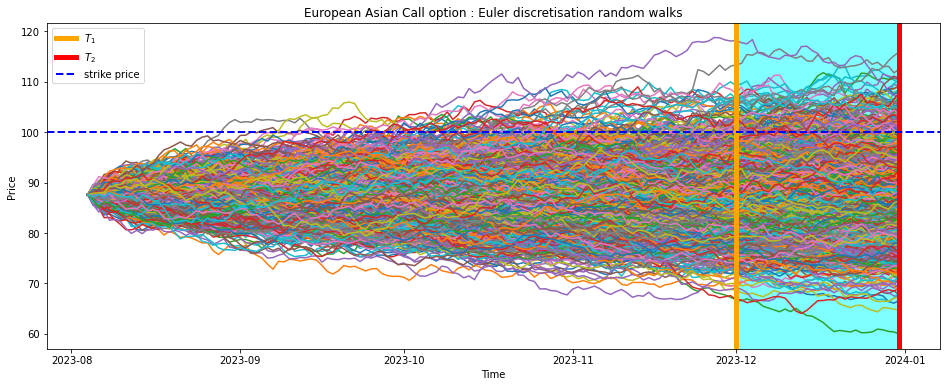

In [362]:
asian_option.plot_asian_paths()

### European Asian Call Option - Average of 30 days before expiry

In [63]:
asian_call_option = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1)
asian_call_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_call_option.get_European_option_price('c')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_call_option.get_Asian_price('c')

asian_call_option_av = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1)
asian_call_option_av.run_monte_carlo(antithetic_variates=True)
(EM_asian_price_av, M_asian_price_av, EM_Asian_SE_av, M_Asian_SE_av) = asian_call_option_av.get_Asian_price('c')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein", "Euler-Maruyama with antithetic variates", "Milstein with antithetic variates"],
        'Option Type': [asian_call_option.main_type, asian_call_option.main_type, asian_call_option.title, asian_call_option.title, asian_call_option_av.title, asian_call_option_av.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price, EM_asian_price_av, M_asian_price_av],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE, EM_Asian_SE_av, M_Asian_SE_av]
    }
)
results

Start running simulations...
Start running simulations...


Method                 Option Type  \
0                           Euler-Maruyama                        Call   
1                                 Milstein                        Call   
2                           Euler-Maruyama  European Asian Call option   
3                                 Milstein  European Asian Call option   
4  Euler-Maruyama with antithetic variates  European Asian Call option   
5        Milstein with antithetic variates  European Asian Call option   

   Estimated Price  Standard Error  
0         0.356767        0.050523  
1         0.357648        0.050614  
2         0.024495        0.009405  
3         0.024705        0.009475  
4         0.015624        0.005386  
5         0.015817        0.005442

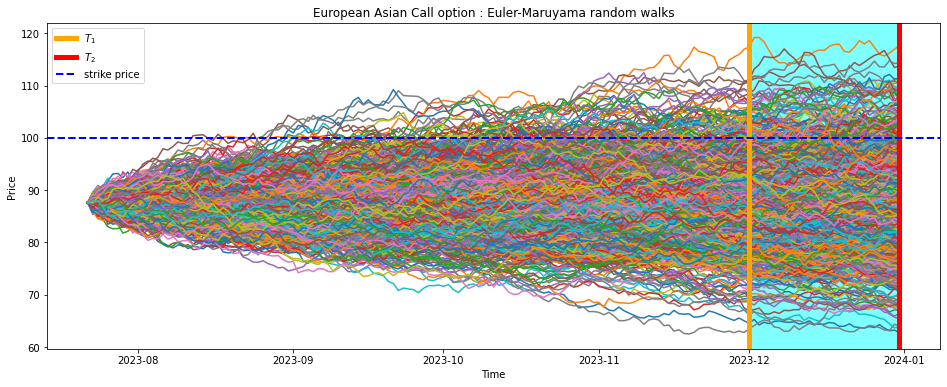

In [64]:
asian_call_option.plot_asian_paths()

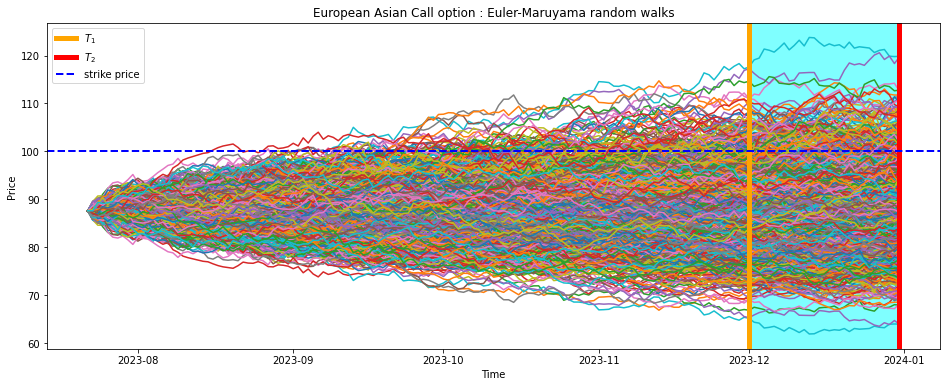

In [65]:
asian_call_option_av.plot_asian_paths()

### European Asian Call Option - Average of 60 days before expiry

In [66]:
T1_60 = date(2023,11,1)
asian_call_option_60 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1_60)
asian_call_option_60.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_call_option_60.get_European_option_price('c')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_call_option_60.get_Asian_price('c')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [asian_call_option_60.main_type, asian_call_option_60.main_type, asian_call_option_60.title, asian_call_option_60.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE]
    }
)
results

Start running simulations...


Method                 Option Type  Estimated Price  Standard Error
0  Euler-Maruyama                        Call         0.350749        0.052280
1        Milstein                        Call         0.350849        0.052407
2  Euler-Maruyama  European Asian Call option         0.015834        0.008283
3        Milstein  European Asian Call option         0.015924        0.008323

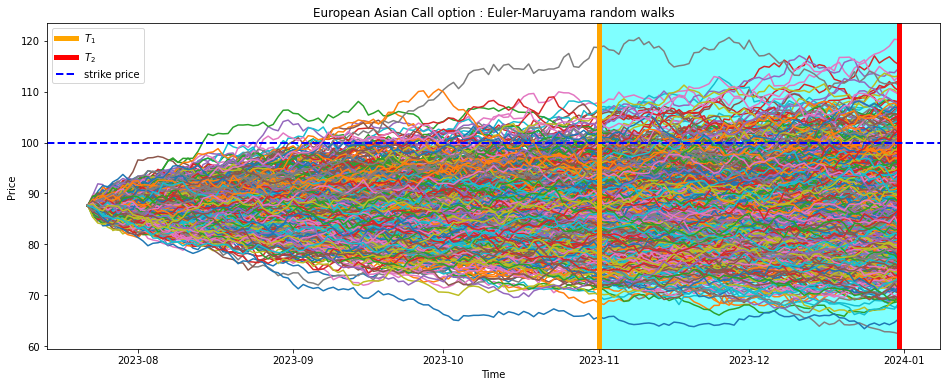

In [67]:
asian_call_option_60.plot_asian_paths()

### European Asian Put Option - Average of 30 days before expiry

In [68]:
asian_put_option = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1)
asian_put_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_put_option.get_European_option_price('p')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_put_option.get_Asian_price('p')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [asian_put_option.main_type, asian_put_option.main_type, asian_put_option.title, asian_put_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE]
    }
)
results

Start running simulations...


Method                Option Type  Estimated Price  Standard Error
0  Euler-Maruyama                        Put        12.410515        0.255334
1        Milstein                        Put        12.410650        0.255375
2  Euler-Maruyama  European Asian Put option        10.566997        0.156631
3        Milstein  European Asian Put option        10.567672        0.156621

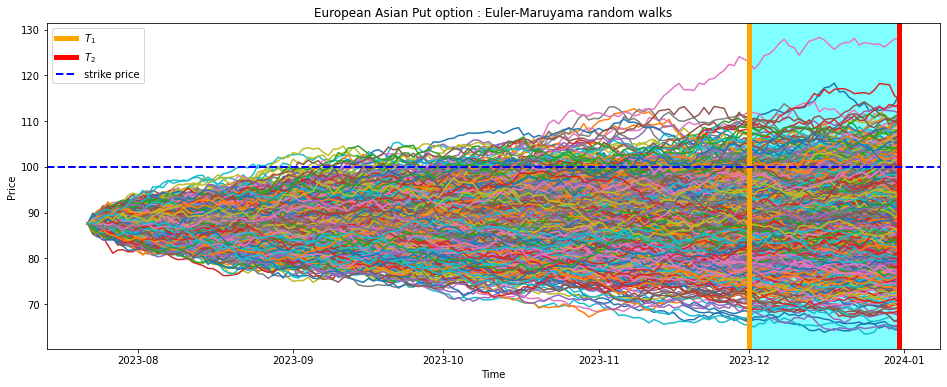

In [69]:
asian_put_option.plot_asian_paths()

### European Asian Put Option - Average of 60 days before expiry

In [70]:
T1_60 = date(2023,11,1)
asian_put_option_60 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1_60)
asian_put_option_60.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_put_option_60.get_European_option_price('p')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_put_option_60.get_Asian_price('p')

asian_put_option_60av = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1_60)
asian_put_option_60av.run_monte_carlo(antithetic_variates=True)
(EM_asian_price_av, M_asian_price_av, EM_Asian_SE_av, M_Asian_SE_av) = asian_put_option_60av.get_Asian_price('p')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein", "Euler-Maruyama with antithetic variates", "Milstein with antithetic variates"],
        'Option Type': [asian_call_option.main_type, asian_call_option.main_type, asian_call_option.title, asian_call_option.title, asian_call_option_av.title, asian_call_option_av.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price, EM_asian_price_av, M_asian_price_av],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE, EM_Asian_SE_av, M_Asian_SE_av]
    }
)
results

Start running simulations...
Start running simulations...


Method                 Option Type  \
0                           Euler-Maruyama                        Call   
1                                 Milstein                        Call   
2                           Euler-Maruyama  European Asian Call option   
3                                 Milstein  European Asian Call option   
4  Euler-Maruyama with antithetic variates  European Asian Call option   
5        Milstein with antithetic variates  European Asian Call option   

   Estimated Price  Standard Error  
0        11.935685        0.247867  
1        11.935400        0.247896  
2        10.623609        0.149418  
3        10.624666        0.149396  
4        10.952198        0.158612  
5        10.953151        0.158618

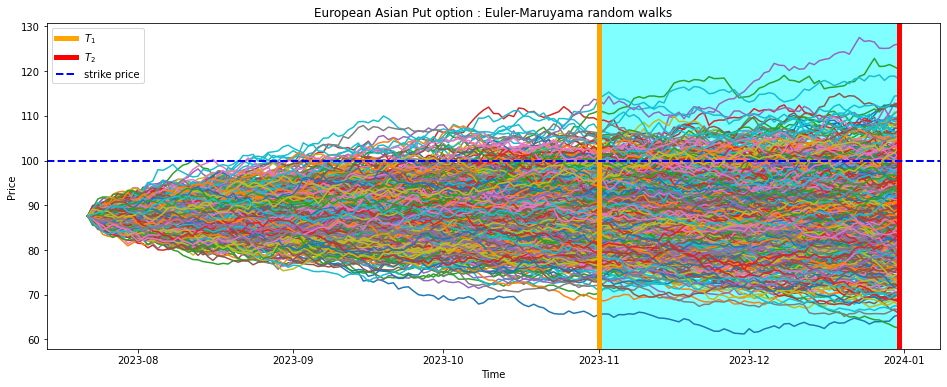

In [71]:
asian_put_option_60.plot_asian_paths()

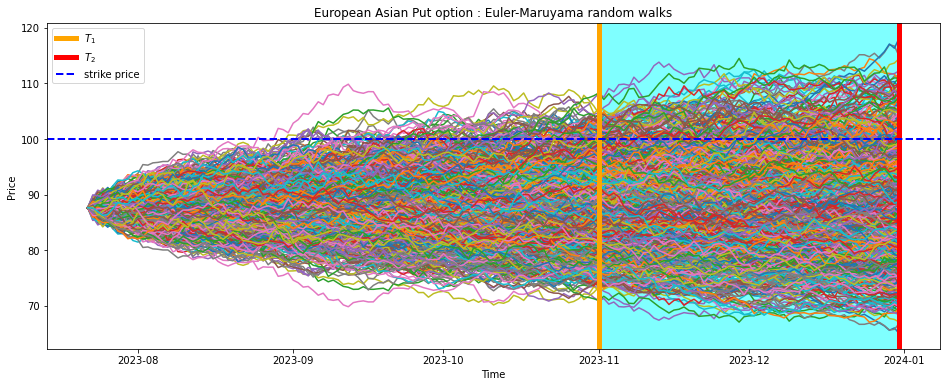

In [72]:
asian_put_option_60av.plot_asian_paths()